In [2]:
from utils import *
import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import scipy
import numpy as np
import cupy as cp
import pandas as pd
import math
import json
from PIL import Image, ImageDraw
from collections import defaultdict
import itertools
from hdv import *

In [3]:
config = Config()
IMAGE_SIZE = config.sample_size

device_marker = np.empty(1)
xp = cp.get_array_module(device_marker)

RNG = xp.random.default_rng()

In [4]:
%%time
IMAGES = []
IMAGES_METADATA = []

with open(os.path.join(config.dataset_path, config.dataset_metadata_file_name)) as f:
    metadata = json.load(f)

for image_fname in tqdm(os.listdir(config.dataset_path)):
    image_fname = os.path.join(config.dataset_path, image_fname)

    if not image_fname.endswith('.png'):
        continue

    # Following fuss with "with" is required to prevent "Too many open files" problem
    with Image.open(image_fname) as image:
        image.load()
        assert image.width == image.height
        assert image.width == IMAGE_SIZE
        assert image.mode == 'L'
        image_index = len(IMAGES)
        IMAGES.append(np.array(image).ravel())
        metadata_record = metadata[os.path.basename(image_fname)]
        metadata_record = np.rec.array([(image_fname, metadata_record.get('value', '?'))], dtype=[('file_name', 'object'), ('value', 'object')])
        IMAGES_METADATA.append(metadata_record)
        
    assert image.fp is None

assert len(IMAGES) == len(IMAGES_METADATA)
IMAGES = np.array(IMAGES)
IMAGES_METADATA = np.rec.array(np.concatenate(IMAGES_METADATA))
print(f'Loaded {len(IMAGES)} images')

  0%|          | 0/10001 [00:00<?, ?it/s]

Loaded 10000 images
CPU times: user 1.67 s, sys: 202 ms, total: 1.87 s
Wall time: 1.87 s


In [5]:
def matrix_to_image(m):
    return Image.frombytes('L', size=(IMAGE_SIZE, IMAGE_SIZE), data=m.reshape(IMAGE_SIZE, IMAGE_SIZE).astype(xp.uint8))

In [6]:
SENSOR_RECEPTIVE_FIELD_SIZE = 8
SENSOR_RECEPTIVE_FIELD_SQUARE = SENSOR_RECEPTIVE_FIELD_SIZE * SENSOR_RECEPTIVE_FIELD_SIZE
SENSOR_GROUP_SIZE = 4
SENSOR_GROUP_SQUARE = SENSOR_GROUP_SIZE * SENSOR_GROUP_SIZE
RETINA_SIZE = 16
RETINA_SQUARE = RETINA_SIZE * RETINA_SIZE


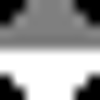
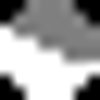
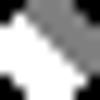
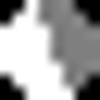
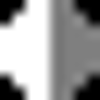
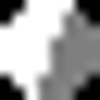
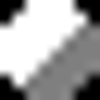
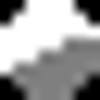
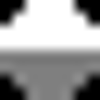
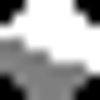
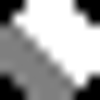
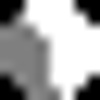
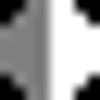
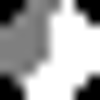
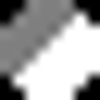
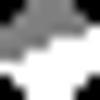

In [7]:
group_sensors_img = []
captions = []
steps = pow(SENSOR_GROUP_SIZE, 2)
sz = RETINA_SIZE * SENSOR_RECEPTIVE_FIELD_SIZE

for i in range(steps):
    canvas = Image.new('L', (sz, sz))
    draw = ImageDraw.Draw(canvas)
    draw.ellipse([0, 0, SENSOR_RECEPTIVE_FIELD_SIZE - 1, SENSOR_RECEPTIVE_FIELD_SIZE - 1], outline=0, fill=127, width=0)
    angle = i * 360 / steps
    draw.chord([0, 0, SENSOR_RECEPTIVE_FIELD_SIZE - 1, SENSOR_RECEPTIVE_FIELD_SIZE - 1], angle, angle + 180, outline=255, fill=255)
    group_sensors_img.append(canvas)
    captions.append(f'#{i} ({i // SENSOR_GROUP_SIZE}, {i % SENSOR_GROUP_SIZE})')

display_images_grid(list(map(lambda x: x.crop([0,0,SENSOR_RECEPTIVE_FIELD_SIZE,SENSOR_RECEPTIVE_FIELD_SIZE]).resize((100, 100)), group_sensors_img)), col_count=SENSOR_GROUP_SIZE, captions=captions)

In [8]:
group_sensors = xp.array(list(map(xp.array, group_sensors_img))).astype(float)
shape_save = group_sensors.shape
group_sensors = group_sensors.reshape(SENSOR_GROUP_SIZE*SENSOR_GROUP_SIZE, -1)
# Due to rough granularity count of positive pixels and negative may be not eqaul => equalize via weight
group_sensors[group_sensors==255] = 1
counts_of_positives = (group_sensors == 1).sum(axis=1)
counts_of_negatives = (group_sensors == 127).sum(axis=1)
white_image = xp.ones(group_sensors.shape[1])

for i, (p, n) in enumerate(zip(counts_of_positives, counts_of_negatives)):
    assert p > 0, (i, p)
    assert n > 0, (i, n)
    group_sensors[i][group_sensors[i] == 127] = -1 * (p / n)
    v = group_sensors[i] @ white_image
    assert xp.isclose(v, 0), v

group_sensors = group_sensors.reshape(shape_save)
group_sensors.shape, np.unique_counts(group_sensors)

((16, 128, 128),
 UniqueCountsResult(values=array([-1.36363636, -1.26086957, -1.16666667, -1.08      , -1.        ,
         0.        ,  1.        ]), counts=array([    44,    138,     48,     50,    104, 261312,    448])))

In [9]:
group_sensors_ones = (group_sensors.reshape(group_sensors.shape[0], -1) == 1).sum(axis=1)
group_sensors_ones, group_sensors_ones.mean(), group_sensors_ones.min(), group_sensors_ones.max(), group_sensors_ones.std()

(array([26, 27, 29, 28, 26, 28, 29, 27, 26, 29, 29, 30, 26, 30, 29, 29]),
 np.float64(28.0),
 np.int64(26),
 np.int64(30),
 np.float64(1.4142135623730951))


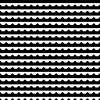
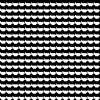
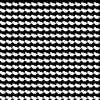
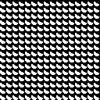
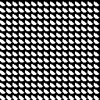
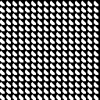
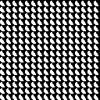
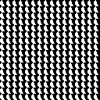
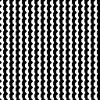
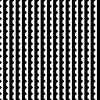
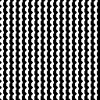
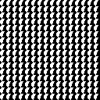
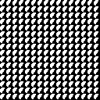
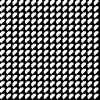
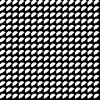
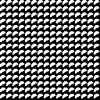
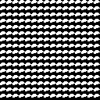
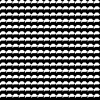
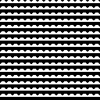
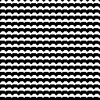
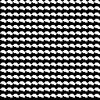
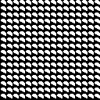
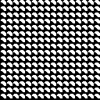
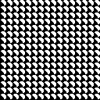
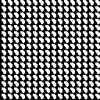
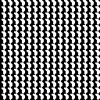
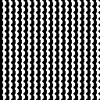
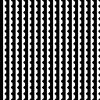
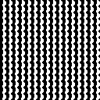
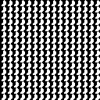
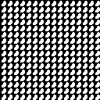
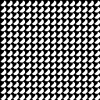
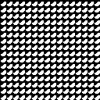
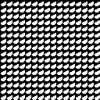
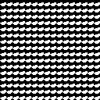
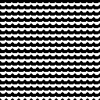

In [10]:
sz = RETINA_SIZE * SENSOR_RECEPTIVE_FIELD_SIZE
steps = 36 # 10 degreee
specific_samples_img = []
captions = []

for i in range(steps):
    canvas = Image.new('L', (sz, sz))
    draw = ImageDraw.Draw(canvas)
    angle = i * 360 / steps
       
    draw.chord([0, 0, SENSOR_RECEPTIVE_FIELD_SIZE - 1, SENSOR_RECEPTIVE_FIELD_SIZE - 1], angle, angle + 180, outline=255, fill=255)
    crop = canvas.crop([0, 0, SENSOR_RECEPTIVE_FIELD_SIZE, SENSOR_RECEPTIVE_FIELD_SIZE])

    for x in range(0, sz, SENSOR_RECEPTIVE_FIELD_SIZE):
        for y in range(0, sz, SENSOR_RECEPTIVE_FIELD_SIZE):
            canvas.paste(crop, [x, y, x + SENSOR_RECEPTIVE_FIELD_SIZE, y + SENSOR_RECEPTIVE_FIELD_SIZE])
            
    specific_samples_img.append(canvas)
    captions.append(f'#{i}')

display_images_grid(list(map(lambda x: x.resize((100, 100)), specific_samples_img)), col_count=int(np.sqrt(steps)), captions=captions)

In [11]:
SPECIFIC_SAMPLES = xp.array(list(map(xp.array, specific_samples_img))).astype(float)
SPECIFIC_SAMPLES[SPECIFIC_SAMPLES==255] = 1
SPECIFIC_SAMPLES = SPECIFIC_SAMPLES.reshape(SPECIFIC_SAMPLES.shape[0], -1)
SPECIFIC_SAMPLES.shape, np.unique_counts(SPECIFIC_SAMPLES)

((36, 16384),
 UniqueCountsResult(values=array([0., 1.]), counts=array([331776, 258048])))

In [12]:
# single sensor occupies (RETINA_SIZE * SENSOR_RECEPTIVE_FIELD_SIZE) ^ 2
# we have group of such sensors stacked under each other in a square fashion, hence SENSOR_GROUP_SIZE^2
# to cover all visual area we have RETINA_SIZE^2 of such groups
retina = xp.zeros((RETINA_SIZE, RETINA_SIZE, pow(SENSOR_GROUP_SIZE, 2), pow(RETINA_SIZE * SENSOR_RECEPTIVE_FIELD_SIZE, 2)))
retina = retina.reshape((RETINA_SIZE, RETINA_SIZE, pow(SENSOR_GROUP_SIZE, 2), -1))

for y in range(RETINA_SIZE):
    for x in range(RETINA_SIZE):
        for g in range(pow(SENSOR_GROUP_SIZE, 2)):
            sensor_at_place = group_sensors[g]
            sensor_at_place = np.roll(sensor_at_place, y * SENSOR_RECEPTIVE_FIELD_SIZE, axis=0)
            sensor_at_place = np.roll(sensor_at_place, x * SENSOR_RECEPTIVE_FIELD_SIZE, axis=1)
            retina[y, x, g, :] = sensor_at_place.reshape(-1)

retina = retina.reshape((-1, pow(RETINA_SIZE * SENSOR_RECEPTIVE_FIELD_SIZE, 2)))
RETINA_POS = retina
RETINA_NEG = retina.copy()

RETINA_POS[RETINA_POS < 0] = 0
RETINA_NEG[RETINA_NEG > 0] = 0

In [13]:
assert xp.array_equal(xp.unique(SPECIFIC_SAMPLES), [0, 1])

specific_samples_sense_pos = RETINA_POS @ SPECIFIC_SAMPLES.T
specific_samples_sense_neg = RETINA_NEG @ SPECIFIC_SAMPLES.T
specific_samples_sense_pos = specific_samples_sense_pos.reshape(RETINA_SIZE, RETINA_SIZE, pow(SENSOR_GROUP_SIZE, 2), -1)
specific_samples_sense_neg = specific_samples_sense_neg.reshape(RETINA_SIZE, RETINA_SIZE, pow(SENSOR_GROUP_SIZE, 2), -1)
specific_samples_sense_ref = specific_samples_sense_pos.copy() # reference
assert specific_samples_sense_pos.shape == specific_samples_sense_neg.shape

# Base for calculations = AREA of illumination must be at least 1/2 of area of positive receptors
# Next we exclude sensors which do not minimal LEVEL of illumination = area * (255 * 10%)
# Finally we exclude sensors which do not have enough contrast (DIFF) - use NEG part of retina and use logarithmic scale (dB)
# For specific samples situation is more straighforward, since is liminiscense is binary (0 or 1)
for y in range(specific_samples_sense_ref.shape[0]):
    for x in range(specific_samples_sense_ref.shape[1]):
        # Matrix of how each group of sensors (rows) perceives each of specific samples (columns)
        perceive_matrix = specific_samples_sense_ref[y, x]
        assert perceive_matrix.shape == (pow(SENSOR_GROUP_SIZE, 2), SPECIFIC_SAMPLES.shape[0])
        cond1 = (perceive_matrix.T / group_sensors_ones).T >= 0.5 # At least half of a positive area of each of sensors is activated

        perceive_matrix_pos = specific_samples_sense_pos[y, x]
        perceive_matrix_neg = xp.abs(specific_samples_sense_neg[y, x])
        assert perceive_matrix_pos.shape == perceive_matrix.shape
        assert perceive_matrix_neg.shape == perceive_matrix.shape

        cond2 = perceive_matrix_pos > perceive_matrix_neg # There is more activation on positive areas than on negative
        assert cond1.shape == cond2.shape
        specific_samples_sense_ref[y, x] = (cond1 & cond2).astype(float)

for i in range(SPECIFIC_SAMPLES.shape[0]):
    v = specific_samples_sense_ref[0, 0, :, i]
    print(f'{v} => {(v == 1).sum()}')

    for y in range(specific_samples_sense_ref.shape[0]):
        for x in range(specific_samples_sense_ref.shape[1]):
            assert xp.array_equal(v, specific_samples_sense_ref[y, x, :, i])

[1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.] => 7
[1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.] => 8
[1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.] => 8
[1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.] => 8
[1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.] => 8
[1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1.] => 8
[1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1.] => 8
[1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.] => 8
[1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.] => 8
[0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.] => 7
[0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.] => 8
[0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.] => 8
[0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.] => 8
[0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.] => 8
[0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0.] => 8
[0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0.] => 8
[0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.] => 8
[0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.] => 8
[0. 0. 0. 

In [14]:
def lay_grid(image, step):
    draw = ImageDraw.Draw(image)

    for c in range(step - 1, image.height, step):
        draw.line([0, c, image.width, c], fill=127)
        draw.line([c, 0, c, image.height], fill=127)

    return image

In [15]:
MINIMAL_ILLUMINATION_ABS_LEVEL = 255 * 0.1
MINIMAL_ILLUMINATION_DIFF_DB = 2 # dB
MINIMAL_ILLUMINATION_DIFF_RATIO = pow(10, MINIMAL_ILLUMINATION_DIFF_DB/20)

def sense_images(images, active_sensors=None):
    active_sensors = xp.ones((RETINA_SQUARE * SENSOR_GROUP_SQUARE, 1)) if active_sensors is None else active_sensors
    assert active_sensors.shape == (RETINA_POS.shape[0], 1)
    sense_ress = []
    image_masks = images.copy()
    image_masks[image_masks > 0] = 1

    effective_retina_pos = RETINA_POS * active_sensors
    effective_retina_neg = RETINA_NEG * active_sensors
    sense_area = (effective_retina_pos @ image_masks.T).T # for check of illuminated area
    sense_level = (effective_retina_pos @ images.T).T # for check of absolute illumination
    sense_neg_level = (effective_retina_neg @ images.T).T # for check of relative diff

    assert sense_area.shape == (len(images), RETINA_SQUARE * SENSOR_GROUP_SQUARE), sense_area.shape
    assert sense_area.shape == sense_level.shape
    assert sense_area.shape == sense_neg_level.shape
    
    # Base for calculations = AREA of illumination must be at least 1/2 of area of positive receptors
    # Next we exclude sensors which do not minimal LEVEL of illumination = area * (255 * 10%)
    # Finally we exclude sensors which do not have enough contrast (DIFF) - use NEG part of retina and use logarithmic scale (dB)
    for sense_area_i, sense_level_i, sense_neg_level_i in zip(sense_area, sense_level, sense_neg_level):
        sense_area_i = sense_area_i.reshape(-1, 16)
        cond1 = (sense_area_i / group_sensors_ones) >= 0.5 # At least half of a positive area of each of sensors is activated
        cond1 = cond1.reshape(-1,)
    
        sense_level_i = sense_level_i.reshape(-1, 16)
        sense_level_i[sense_level_i <= 0] = 1e-6 # to ease cond3
        cond2 = (sense_level_i > MINIMAL_ILLUMINATION_ABS_LEVEL * group_sensors_ones) # Illumination level of an area must exceed given threshold
        cond2 = cond2.reshape(-1,)
    
        sense_neg_level_i = xp.abs(sense_neg_level_i)
        sense_neg_level_i[sense_neg_level_i <= 0] = 1e-6 # to ease cond3
        cond3 = (sense_level_i.reshape(-1,) / sense_neg_level_i) >= MINIMAL_ILLUMINATION_DIFF_RATIO # Illumination of positive area must be > illumination of negative one
    
        sense_res = (cond1 & cond2 & cond3).astype(int) # mask of active sensors for particular image
        sense_ress.append(sense_res)

    return xp.array(sense_ress)

In [16]:
drifts = []
drift_range = range(-4, 6, 2)

for i in drift_range:
    for j in drift_range:
        drifts.append((i,j))   

In [17]:
def get_image_drifts(image):
    images = []

    for drift in drifts:
        image_drifted = image.reshape(IMAGE_SIZE, IMAGE_SIZE)
        image_drifted = np.roll(image_drifted, drift[0], axis=0)
        rows_to_wipeout = [min(drift[0], 0) + i for i in range(abs(drift[0]))]
        image_drifted[rows_to_wipeout,:] = 0
        image_drifted = np.roll(image_drifted, drift[1], axis=1)
        cols_to_wipeout = [min(drift[1], 0) + i for i in range(abs(drift[1]))]
        image_drifted[:,cols_to_wipeout] = 0
        image_drifted = image_drifted.reshape(-1)
        images.append(image_drifted)

    return xp.array(images)


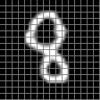
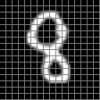
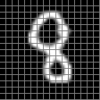
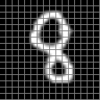
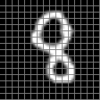
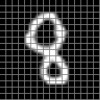
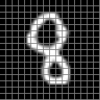
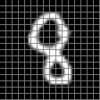
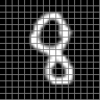
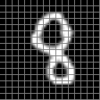
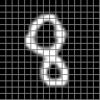
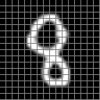
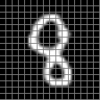
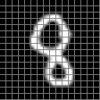
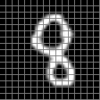
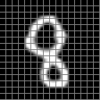
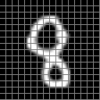
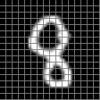
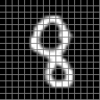
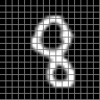
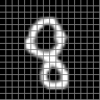
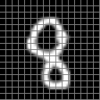
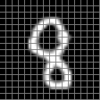
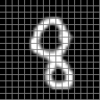
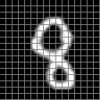
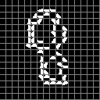
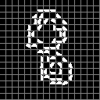
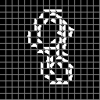
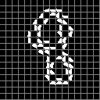
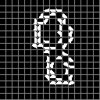
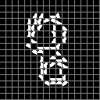
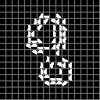
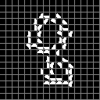
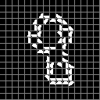
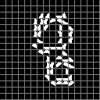
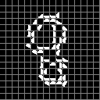
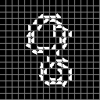
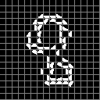
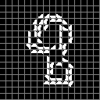
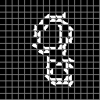
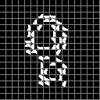
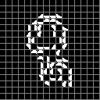
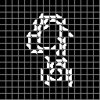
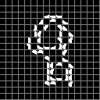
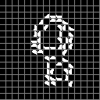
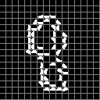
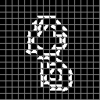
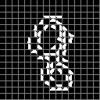
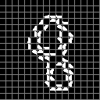
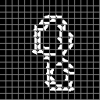

In [67]:
image_index = 6835
image = IMAGES[image_index]
images = get_image_drifts(image)
sensor_activationss = sense_images(images)
sensor_map_images = []

for sensor_activations in sensor_activationss:
    sensor_activations = sensor_activations.reshape(RETINA_SIZE, RETINA_SIZE, SENSOR_GROUP_SQUARE)
    sz = RETINA_SIZE * SENSOR_RECEPTIVE_FIELD_SIZE
    sensor_map_image = xp.zeros((sz, sz))

    for y in range(RETINA_SIZE):
        for x in range(RETINA_SIZE):
            sensors_in_group = sensor_activations[y, x]
            assert sensors_in_group.shape == (SENSOR_GROUP_SQUARE,)

            if xp.any(sensors_in_group > 0):
                # Find most similar reaction among specific samples of reactions
                a = sensors_in_group
                b = specific_samples_sense_ref[y, x, :]
                sense_vector_cos_sim = (a @ b)/(xp.linalg.norm(a) * xp.linalg.norm(b, axis=0))
                best_i = xp.argmax(sense_vector_cos_sim)
                most_similar_specific_sample = SPECIFIC_SAMPLES[best_i].reshape((sz, sz))
                srfs = SENSOR_RECEPTIVE_FIELD_SIZE
                xp.copyto(sensor_map_image[y*srfs:(y+1)*srfs, x*srfs:(x+1)*srfs], most_similar_specific_sample[y*srfs:(y+1)*srfs, x*srfs:(x+1)*srfs])

    sensor_map_images.append(sensor_map_image * 255)

images_to_display = list(images) + sensor_map_images
images_to_display = map(lambda x: matrix_to_image(x), images_to_display)
images_to_display = map(lambda x: lay_grid(x, SENSOR_RECEPTIVE_FIELD_SIZE), images_to_display)
images_to_display = map(lambda x: x.resize((100, 100)), images_to_display)
display_images_grid(list(images_to_display), col_count=len(images))


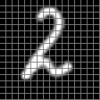
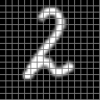
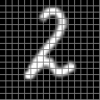
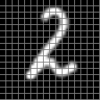
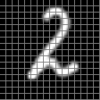
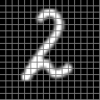
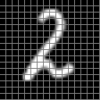
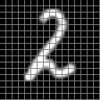
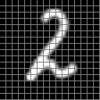
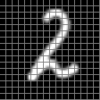
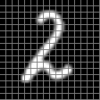
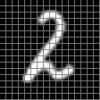
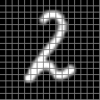
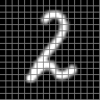
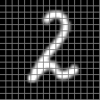
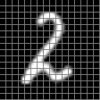
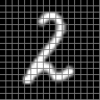
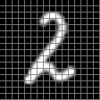
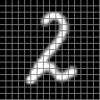
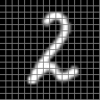
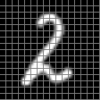
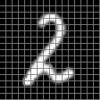
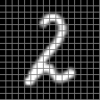
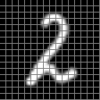
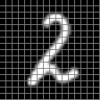
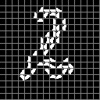
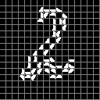
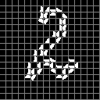
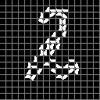
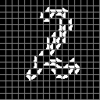
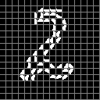
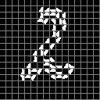
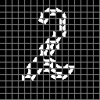
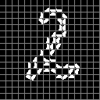
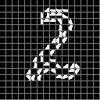
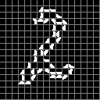
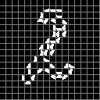
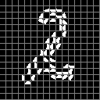
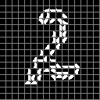
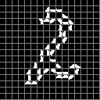
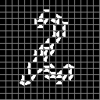
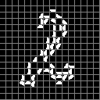
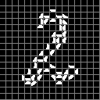
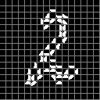
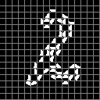
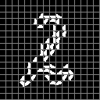
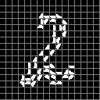
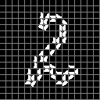
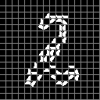
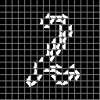

In [69]:
image_index = 2142
image = IMAGES[image_index]
images = get_image_drifts(image)
sensor_activationss = sense_images(images)
sensor_map_images = []

for sensor_activations in sensor_activationss:
    sensor_activations = sensor_activations.reshape(RETINA_SIZE, RETINA_SIZE, SENSOR_GROUP_SQUARE)
    sz = RETINA_SIZE * SENSOR_RECEPTIVE_FIELD_SIZE
    sensor_map_image = xp.zeros((sz, sz))

    for y in range(RETINA_SIZE):
        for x in range(RETINA_SIZE):
            sensors_in_group = sensor_activations[y, x]
            assert sensors_in_group.shape == (SENSOR_GROUP_SQUARE,)

            if xp.any(sensors_in_group > 0):
                # Find most similar reaction among specific samples of reactions
                a = sensors_in_group
                b = specific_samples_sense_ref[y, x, :]
                sense_vector_cos_sim = (a @ b)/(xp.linalg.norm(a) * xp.linalg.norm(b, axis=0))
                best_i = xp.argmax(sense_vector_cos_sim)
                most_similar_specific_sample = SPECIFIC_SAMPLES[best_i].reshape((sz, sz))
                srfs = SENSOR_RECEPTIVE_FIELD_SIZE
                xp.copyto(sensor_map_image[y*srfs:(y+1)*srfs, x*srfs:(x+1)*srfs], most_similar_specific_sample[y*srfs:(y+1)*srfs, x*srfs:(x+1)*srfs])

    sensor_map_images.append(sensor_map_image * 255)

images_to_display = list(images) + sensor_map_images
images_to_display = map(lambda x: matrix_to_image(x), images_to_display)
images_to_display = map(lambda x: lay_grid(x, SENSOR_RECEPTIVE_FIELD_SIZE), images_to_display)
images_to_display = map(lambda x: x.resize((100, 100)), images_to_display)
display_images_grid(list(images_to_display), col_count=len(images))

In [393]:
COS_SIM_THRESHOLD = 0.075
hdv = Hdv(10_000, xp)

In [394]:
SENSOR_GROUP_HDV_DB = defaultdict(hdv)
IMAGE_HDV_DB = xp.zeros(shape=(0, hdv.N), dtype='b')
IMAGE_NORM_HDV_DB = xp.zeros(shape=(0, hdv.N))
IMAGE_INDEX_TO_IMAGE_NORM_HDV_INDEX = dict()
IMAGE_NORM_HDV_INDEX_TO_IMAGE_INDEX = dict()

In [395]:
count = 100
sensor_activationss = sense_images(IMAGES[:count]) # shape: image, sensor_activations for an image. E.g. (count, 4096)

for image_index, sensor_activations in enumerate(sensor_activationss):
    # sensor_activations = sensor activations for given image; shape=(4096,)
    image_hdv = []
    
    for i in range(0, len(sensor_activations), SENSOR_GROUP_SQUARE):
        sensor_activations_group = sensor_activations[i:i+SENSOR_GROUP_SQUARE]

        if xp.any(sensor_activations_group > 0):
            sensor_activations_group_pulp = ''.join(map(str, sensor_activations_group.tolist()))
            sensor_activations_group_code = f'[{sensor_activations_group_pulp}]@{i}'
            image_hdv.append(SENSOR_GROUP_HDV_DB[sensor_activations_group_code])

    if not image_hdv: # empty image (neither sensor got activated)
        print(f'WARN! Empty image detected #{image_index}')
        continue

    image_hdv = hdv.bundle_noties(image_hdv)
    image_norm_hdv = hdv.normalize(image_hdv)

    cos_sims = IMAGE_NORM_HDV_DB @ image_norm_hdv # this will compute cos sim against all HDVs in DB

    for _ in range(1):
        if cos_sims.size > 0:
            max_cos_sim_index = xp.argmax(cos_sims)
    
            if cos_sims[max_cos_sim_index] >= COS_SIM_THRESHOLD:
                break
    else:
        # No similar image found, register new one
        IMAGE_HDV_DB = xp.append(IMAGE_HDV_DB, [image_hdv], axis=0)
        IMAGE_NORM_HDV_DB = xp.append(IMAGE_NORM_HDV_DB, [image_norm_hdv], axis=0)
        norm_hdv_index = IMAGE_NORM_HDV_DB.shape[0] - 1
        assert norm_hdv_index >= 0
        IMAGE_INDEX_TO_IMAGE_NORM_HDV_INDEX[image_index] = norm_hdv_index
        IMAGE_NORM_HDV_INDEX_TO_IMAGE_INDEX[norm_hdv_index] = image_index

In [411]:
len(SENSOR_GROUP_HDV_DB), IMAGE_NORM_HDV_DB.shape

(5603, (69, 10000))

In [412]:
def find_image_prototypes1(image):
    image_drifts = get_image_drifts(image)
    sensor_activationss = sense_images(image_drifts) # shape: image_drift, sensor_activations for image_drift. E.g. (25, 4096)
    image_drift_hdvs = []
    result = []
    
    for sensor_activations in sensor_activationss:
        # sensor_activations = sensor activations for next image_drift, e.g. shape=(4096,)
        image_drift_hdv = []
        
        for i in range(0, len(sensor_activations), SENSOR_GROUP_SQUARE):
            sensor_activations_group = sensor_activations[i:i+SENSOR_GROUP_SQUARE]

            if xp.any(sensor_activations_group > 0):
                sensor_activations_group_pulp = ''.join(map(str, sensor_activations_group.tolist()))
                sensor_activations_group_code = f'[{sensor_activations_group_pulp}]@{i}'
                image_drift_hdv.append(SENSOR_GROUP_HDV_DB[sensor_activations_group_code])

        if not image_drift_hdv: # empty image (neither sensor got activated)
            continue

        image_drift_hdv = hdv.bundle_noties(image_drift_hdv)
        image_drift_norm_hdv = hdv.normalize(image_drift_hdv)

        cos_sims = IMAGE_NORM_HDV_DB @ image_drift_norm_hdv # this will compute cos sim against all HDVs in DB

        if cos_sims.size > 0:
            max_cos_sim_index = xp.argmax(cos_sims)

            if max_cos_sim_index > -1 and cos_sims[max_cos_sim_index] >= COS_SIM_THRESHOLD:
                rec = (IMAGE_NORM_HDV_INDEX_TO_IMAGE_INDEX[max_cos_sim_index], cos_sims[max_cos_sim_index])
                result.append(rec)

    result.sort(key=lambda x: -x[1]) # sort asc by cos sim 
    return result


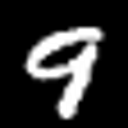
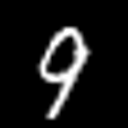
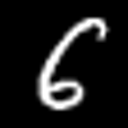
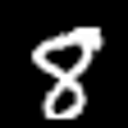
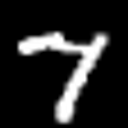
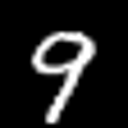
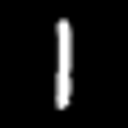
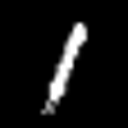
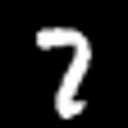
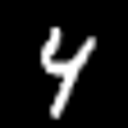
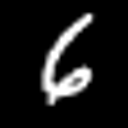
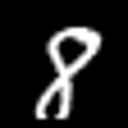
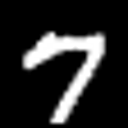
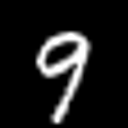
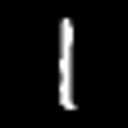
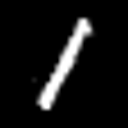
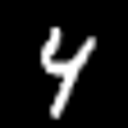
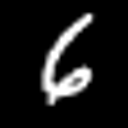
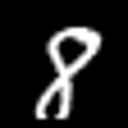
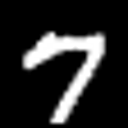
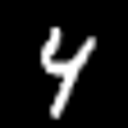
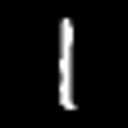
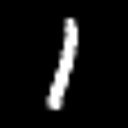
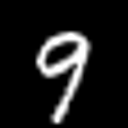
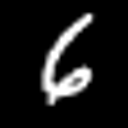
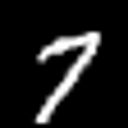
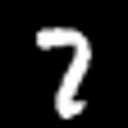
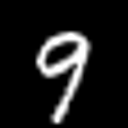
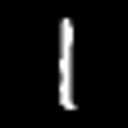
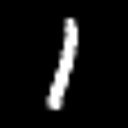

In [455]:
count = 8
images_row = []
image_protos_rows = [[], [], []]
images_captions = []
image_protos_captions = [[], [], []]

def get_image_safe(index):
    if index < 0:
        return Image.new('L', size=(1,1), color=255)
        
    return matrix_to_image(IMAGES[index])

# test_image_indices = RNG.choice(range(5000, len(IMAGES)), 8)

for image_index in test_image_indices:
    images_row.append(image_index)
    images_captions.append(image_index)
    
    image_protos = find_image_prototypes1(IMAGES[image_index])

    for row, captions, image_proto in itertools.zip_longest(image_protos_rows, image_protos_captions, image_protos):
        if row is None:
            break
            
        image_proto_index, cos_sim = (-1, 0) if image_proto is None else image_proto
        row.append(image_proto_index)
        captions.append(f'{image_proto_index}, {cos_sim:.2f}')

display_images_grid(list(map(get_image_safe, images_row + list(itertools.chain.from_iterable(image_protos_rows)))), 
                    col_count=count, 
                    captions=images_captions + list(itertools.chain.from_iterable(image_protos_captions)))

In [468]:
SENSOR_GROUP_SUBSPACE_COUNT = 25
SENSOR_GROUP_SUBSPACE_WIDTH = RETINA_SQUARE // 12

class SensorGroupSubspace(object):
    def __init__(self):
        self.sensor_group_indices = RNG.choice(RETINA_SQUARE, SENSOR_GROUP_SUBSPACE_WIDTH, replace=False)
        self.sensor_group_indices *= SENSOR_GROUP_SQUARE
        assert xp.all(xp.unique_counts(self.sensor_group_indices).counts == 1)
        self.norm_hdvs = xp.zeros(shape=(0, hdv.N))
        self.image_index_to_norm_hdv_index = dict()
        self.norm_hdv_index_to_image_index = dict()
        self.work_norm_hdv = None

    def remember_work(self, image_index):
        if self.work_norm_hdv is None:
            return

        assert image_index > -1
        assert self.work_norm_hdv.shape == (hdv.N,)
        self.norm_hdvs = xp.append(self.norm_hdvs, [self.work_norm_hdv], axis=0)
        norm_hdv_index = self.norm_hdvs.shape[0] - 1
        assert norm_hdv_index >= 0
        self.image_index_to_norm_hdv_index[image_index] = norm_hdv_index
        self.norm_hdv_index_to_image_index[norm_hdv_index] = image_index

In [474]:
sensor_group_subspaces = dict()

for i in range(SENSOR_GROUP_SUBSPACE_COUNT):
    sensor_group_subspaces[i] = SensorGroupSubspace()

In [476]:
count = 100
sensor_activationss = sense_images(IMAGES[:count]) # shape: image, sensor_activations for an image. E.g. (count, 4096)

for image_index, sensor_activations in enumerate(sensor_activationss):
    # sensor_activations = sensor activations for given image; shape=(4096,)
    consensus_table = pd.DataFrame([[-1, -1, 0]], columns=['subspace_index', 'image_index', 'sim']) # fake row to ease pivoting later

    # Ощупываем image с разных сторон 
    for subspace_index, subspace in sensor_group_subspaces.items():
        subspace.work_norm_hdv = []
    
        for sensor_group_index in subspace.sensor_group_indices:
            sensor_group = sensor_activations[sensor_group_index:sensor_group_index+SENSOR_GROUP_SQUARE]

            if xp.any(sensor_group > 0):
                sensor_group_pulp = ''.join(map(str, sensor_group.tolist()))
                sensor_group_code = f'[{sensor_group_pulp}]@{sensor_group_index}'
                subspace.work_norm_hdv.append(SENSOR_GROUP_HDV_DB[sensor_group_code])

        if not subspace.work_norm_hdv:
            subspace.work_norm_hdv = None
        else:
            subspace.work_norm_hdv = hdv.bundle_noties(subspace.work_norm_hdv)
            subspace.work_norm_hdv = hdv.normalize(subspace.work_norm_hdv)
        
            cos_sims = subspace.norm_hdvs @ subspace.work_norm_hdv # this will compute cos sim against all HDVs
            candidate_hdv_indices = xp.argwhere(cos_sims >= COS_SIM_THRESHOLD).reshape(-1)

            for candidate_hdv_index in candidate_hdv_indices:
                cos_sim = cos_sims[candidate_hdv_index]
                candidate_image_index = subspace.norm_hdv_index_to_image_index[candidate_hdv_index]
                consensus_table.loc[len(consensus_table)] = [subspace_index, candidate_image_index, cos_sim]

    # Попытка договориться о том, что мы видим через консенсус
    consensus_pivot = pd.pivot_table(consensus_table, index='image_index', values=['sim'], aggfunc=['count', 'mean', 'sum'], sort=False)
    consensus_pivot = consensus_pivot[(consensus_pivot.index > -1) & (consensus_pivot[('count', 'sim')] > len(sensor_group_subspaces) / 2)]
    #consensus_pivot.sort_values(by=[('count', 'sim'), ('mean', 'sim')], ascending=[False, False], inplace=True)
    consensus_pivot.sort_values(by=[('sum', 'sim')], ascending=[False], inplace=True)

    if len(consensus_pivot) > 0:
        # print(f'Something familiar encountered for {image_index}')
        pass
    else:
        # print(f'Something new encountered for {image_index}')
        
        for subspace in sensor_group_subspaces.values():
            subspace.remember_work(image_index)

In [477]:
def find_image_prototypes2(image):
    image_drifts = get_image_drifts(image)
    sensor_activations_for_drifts = sense_images(image_drifts) 
    image_drift_hdvs = []
    consensus_table = pd.DataFrame([[-1, -1, -1, 0]], columns=['image_drift_index', 'subspace_index', 'image_index', 'sim']) # fake row to ease pivoting later
    
    for image_drift_index, sensor_activations in enumerate(sensor_activations_for_drifts):
        # sensor_activations = sensor activations for next image_drift, e.g. shape=(4096,)

        # Ощупываем image_drift с разных сторон 
        for subspace_index, subspace in sensor_group_subspaces.items():
            subspace.work_norm_hdv = []
        
            for sensor_group_index in subspace.sensor_group_indices:
                sensor_group = sensor_activations[sensor_group_index:sensor_group_index+SENSOR_GROUP_SQUARE]
    
                if xp.any(sensor_group > 0):
                    sensor_group_pulp = ''.join(map(str, sensor_group.tolist()))
                    sensor_group_code = f'[{sensor_group_pulp}]@{sensor_group_index}'
                    subspace.work_norm_hdv.append(SENSOR_GROUP_HDV_DB[sensor_group_code])
    
            if not subspace.work_norm_hdv:
                subspace.work_norm_hdv = None
            else:
                subspace.work_norm_hdv = hdv.bundle_noties(subspace.work_norm_hdv)
                subspace.work_norm_hdv = hdv.normalize(subspace.work_norm_hdv)
            
                cos_sims = subspace.norm_hdvs @ subspace.work_norm_hdv # this will compute cos sim against all HDVs
                candidate_hdv_indices = xp.argwhere(cos_sims >= COS_SIM_THRESHOLD).reshape(-1)
    
                for candidate_hdv_index in candidate_hdv_indices:
                    cos_sim = cos_sims[candidate_hdv_index]
                    candidate_image_index = subspace.norm_hdv_index_to_image_index[candidate_hdv_index]
                    consensus_table.loc[len(consensus_table)] = [image_drift_index, subspace_index, candidate_image_index, cos_sim]

    # Попытка договориться о том, что мы видим через консенсус
    consensus_pivot = pd.pivot_table(consensus_table, index=['image_drift_index', 'image_index'], values=['sim'], aggfunc=['count', 'mean', 'sum'], sort=False)
    consensus_pivot = consensus_pivot[(consensus_pivot[('mean', 'sim')] > 0) & (consensus_pivot[('count', 'sim')] > len(sensor_group_subspaces) / 2)]
    # consensus_pivot.sort_values(by=[('count', 'sim'), ('mean', 'sim')], ascending=[False, False], inplace=True)
    consensus_pivot.sort_values(by=[('sum', 'sim')], ascending=[False], inplace=True)
    return consensus_pivot, consensus_table


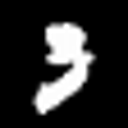
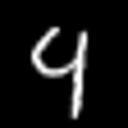
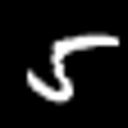
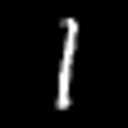
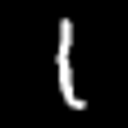
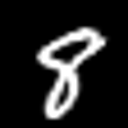
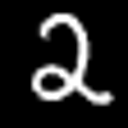
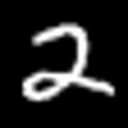
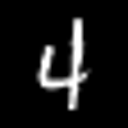
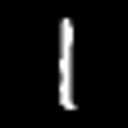
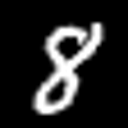
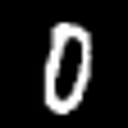
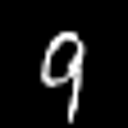
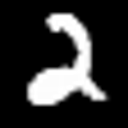
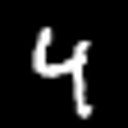
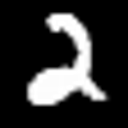

In [481]:
count = 8
images_row = []
image_protos_rows = [[], [], []]
images_captions = []
image_protos_captions = [[], [], []]

def get_image_safe(index):
    if index < 0:
        return Image.new('L', size=(1,1), color=255)
        
    return matrix_to_image(IMAGES[index])

test_image_indices = RNG.choice(range(5000, len(IMAGES)), count)
    
for image_index in test_image_indices:
    images_row.append(image_index)
    images_captions.append(image_index)
    
    image_protos, consensus_table = find_image_prototypes2(IMAGES[image_index])
    # break

    for row, captions, image_proto in itertools.zip_longest(image_protos_rows, image_protos_captions, image_protos.iterrows()):
        if row is None:
            break
            
        image_proto_index, cos_sim = (-1, 0) if image_proto is None else (int(image_proto[0][1]), image_proto[1][('mean', 'sim')])
        row.append(image_proto_index)
        captions.append(f'{image_proto_index}, {cos_sim:.2f}')

display_images_grid(list(map(get_image_safe, images_row + list(itertools.chain.from_iterable(image_protos_rows)))), 
                    col_count=count, 
                    captions=images_captions + list(itertools.chain.from_iterable(image_protos_captions)))

In [479]:
consensus_table

,image_drift_index,subspace_index,image_index,sim
0,-1.0,-1.0,-1.0,0.000000
1,0.0,0.0,35.0,0.338616
2,0.0,1.0,83.0,0.159683
3,0.0,2.0,27.0,0.177874
4,0.0,2.0,31.0,0.131256
...,...,...,...,...
3434,24.0,22.0,48.0,0.194933
3435,24.0,22.0,63.0,0.222076
3436,24.0,23.0,3.0,0.179739
3437,24.0,24.0,3.0,0.337914


In [480]:
image_protos

count      mean       sum
                                sim       sim       sim
image_drift_index image_index                          
2.0               75.0           13  0.207507  2.697591
                  3.0            13  0.180300  2.343897


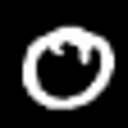
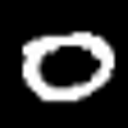

In [266]:
image_index = 7170
image_prototype_index = -1

image_drifts = get_image_drifts(IMAGES[image_index])
sensor_activationss = sense_images(image_drifts) # shape: image_drift, sensor_activations for image_drift. E.g. (25, 4096)
image_drift_hdvs = []

for sensor_activations in sensor_activationss:
    # sensor_activations = sensor activations for next image_drift, e.g. shape=(4096,)
    image_drift_hdv = []
    
    for i in range(0, len(sensor_activations), SENSOR_GROUP_SQUARE):
        sensor_activations_group = sensor_activations[i:i+SENSOR_GROUP_SQUARE]

        if xp.any(sensor_activations_group > 0):
            sensor_activations_group_pulp = ''.join(map(str, sensor_activations_group.tolist()))
            sensor_activations_group_code = f'[{sensor_activations_group_pulp}]@{i}'
            image_drift_hdv.append(SENSOR_GROUP_HDV_DB[sensor_activations_group_code])

    if not image_drift_hdv: # empty image (neither sensor got activated)
        continue

    image_drift_hdv = bundle_noties(image_drift_hdv)
    image_drift_norm_hdv = normalize(image_drift_hdv)

    cos_sims = IMAGE_NORM_HDV_DB @ image_drift_norm_hdv # this will compute cos sim against all HDVs in DB

    if cos_sims.size > 0:
        max_cos_sim_index = xp.argmax(cos_sims)

        if max_cos_sim_index > -1 and cos_sims[max_cos_sim_index] >= COS_SIM_THRESHOLD:
            image_prototype_index = IMAGE_NORM_HDV_INDEX_TO_IMAGE_INDEX[max_cos_sim_index]

display_images(list(map(lambda i: matrix_to_image(IMAGES[i]), [image_index, image_prototype_index])), captions=[image_index, image_prototype_index])

In [530]:
sz1 = 8
sz2 = 5
trials = 0
test_ints = RNG.integers(10, size=sz1)

while True:
    x = RNG.integers(10, size=sz2)

    if np.array_equal(x, test_ints[:sz2]):
        break
        
    trials += 1

trials, 1 / trials

(261120, 3.829656862745098e-06)

In [524]:
sz = 5
trials = 0
test_ints = RNG.integers(10, size=sz)
current_i = 0

while current_i < len(test_ints):
    x = RNG.integers(10)

    if x == test_ints[current_i]:
        current_i += 1
        
    trials += 1

trials, 1 / trials

(76, 0.013157894736842105)

In [574]:
RNG.normal(0, 5, size=(20, 2)).astype(int)

array([[-5,  5],
       [ 3,  5],
       [ 0,  2],
       [ 3,  1],
       [ 0,  1],
       [ 1, -2],
       [ 4, -9],
       [ 6,  2],
       [-6, -4],
       [-1,  0],
       [ 0, -5],
       [ 3, -2],
       [ 2,  2],
       [-4,  2],
       [-6,  2],
       [ 2,  0],
       [ 3,  6],
       [-2,  3],
       [ 5,  3],
       [ 3, -8]])